<a href="https://colab.research.google.com/github/MarkusFranke/RNA-Half-life-for-tissues/blob/main/models-for-general-half-life/Checking_Motifs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from Bio import SeqIO #for parsing Fasta Files
import pandas as pd
from scipy.stats import zscore
from kipoiseq.transforms.functional import one_hot, fixed_len
import numpy as np
import math

from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as k
from keras.callbacks import EarlyStopping, History
from keras.models import Model
import tensorflow_addons as tfa
import tensorflow as tf
import keras.layers as kl
import keras
import numpy as np
import os
import subprocess
import gc

import seaborn as sns
import matplotlib.pyplot as plt

Since we can't run this in google colab due to RAM limitations, I'm importing the data from disk. All the data should be available on google drive though, under the same filenames, either to be downloaded and run with a path to where the user saved them, or to be directly accessible by mounting the google drive (and setting a shortcut to our google drive data path in google drive)


In [ ]:
hl = pd.read_excel(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\kelley_et_al_corrected_hl.xlsx', skiprows=[0, 1])
hl['zscore'] = zscore(hl['half-life (PC1)'])
halflife = hl[["Ensembl Gene Id", "zscore"]]
hl

,Ensembl Gene Id,Gene name,half-life (PC1),Bazzini_ActD_HEK293_1,Bazzini_ActD_HeLa_1,Bazzini_ActD_RPE_1,Bazzini_4sU_K562_1,Akimitsu_BrU_HeLa_1,Rinn_ActD_K562_1,Rinn_ActD_K562_2,...,Gejman_4sU_GM12812_1,Gejman_4sU_GM12814_1,Gejman_4sU_GM12815_1,Simon_4sU_K562_1,Simon_4sU_K562_2,Rissland_4sU_HEK293_1,Rissland_4sU_HEK293_2,Rissland_4sU_HEK293_3,Rissland_4sU_HEK293_4,zscore
0,ENSG00000000003,TSPAN6,8.660955,0.763166,0.258448,0.106486,1.019072,2.022504,1.744745,1.783356,...,1.037361,0.969166,1.209562,2.080643,2.095154,0.674058,1.120375,1.456258,1.791769,1.807620
1,ENSG00000000419,DPM1,2.241221,0.529938,0.222678,-0.040666,-0.284952,0.145097,0.866919,0.832768,...,-0.212424,-0.747989,0.371214,0.772595,0.712843,-0.350914,-0.879247,-0.825603,0.109861,0.467763
2,ENSG00000000457,SCYL3,-6.929173,-0.798471,-0.894854,-1.039150,-1.444532,-1.287191,-1.006317,-1.062201,...,-1.155096,-1.421651,-1.568912,-1.308978,-1.311572,-0.387172,-1.229226,-1.122749,-0.570002,-1.446182
3,ENSG00000000460,C1orf112,0.440909,0.461228,0.195794,-0.739672,-0.123925,0.162538,-0.023056,-0.008479,...,1.365208,1.017193,-0.239569,0.373929,0.380154,-0.063720,-0.450610,-0.805719,0.453957,0.092022
4,ENSG00000000938,FGR,-0.943680,0.164310,0.112064,0.095773,0.045345,0.024136,-0.209157,-0.223700,...,0.722198,1.024313,1.484018,-0.375671,-0.384504,0.232924,0.347933,0.266619,0.063565,-0.196955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13916,ENSG00000284770,TBCE,2.218664,0.100281,-0.187624,-0.143422,0.201024,0.933352,0.465403,0.451758,...,1.082013,0.917651,0.897480,0.866792,0.868080,-0.104068,-0.169414,-0.404886,-0.165188,0.463055
13917,ENSG00000285077,ARHGAP11B,-3.262964,-0.733980,-0.934478,-0.952570,-0.461339,-0.940048,0.225157,0.161858,...,0.256969,0.033071,-0.249782,-1.116405,-1.078302,-1.495412,-1.006317,-1.240272,-1.440629,-0.681011
13918,ENSG00000288596,C8orf44,2.118850,-0.485957,-0.320560,-0.332189,0.582473,-0.614775,0.305297,0.336730,...,1.023526,-0.155662,-0.950892,-0.175193,-0.166760,2.505294,1.068162,1.307039,1.563308,0.442223
13919,ENSG00000288701,PRRC2B,0.133147,0.133770,0.214899,0.144491,0.090991,0.131956,-0.040831,-0.035576,...,-0.091563,-0.021327,-0.017414,0.088581,0.107441,0.345123,-0.188176,-0.119128,0.001050,0.027789


In [ ]:
with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.3pUTRs.fa') as fasta_file:  # Will close handle cleanly
    UTR3_identifiers = []
    UTR3_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        UTR3_identifiers.append(seq_record.id)
        UTR3_seqs.append(seq_record.seq)

with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.5pUTRs.fa') as fasta_file:  # Will close handle cleanly
    UTR5_identifiers = []
    UTR5_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        UTR5_identifiers.append(seq_record.id)
        UTR5_seqs.append(seq_record.seq)

with open(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Homo_sapiens.GRCh38.83.chosenTranscript.ORFs.fa') as fasta_file:  # Will close handle cleanly
    ORF_identifiers = []
    ORF_seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        ORF_identifiers.append(seq_record.id)
        ORF_seqs.append(seq_record.seq)

print(UTR3_seqs[0])
print(UTR5_seqs[0])
print(ORF_seqs[0])
print(UTR3_identifiers[0])
print(UTR5_identifiers[0])
print(ORF_identifiers[0])
print(len(UTR3_seqs))
print(len(UTR5_seqs))
print(len(ORF_seqs))

AATATTATGTATGCAGCAATATTTGAGTAACAAGAAGCAAATATCCAAGTTCCAAAATTATAAAAGAAATTCTTATCCAAATAGTAATGTTCTAATTGATCATATAAGAAAGCAAAGCATAGACATTAGAATTATAAGTCAGCAGTGGTCTGTTCAAGAACAATCAACATTTTTAGAAAATAGTAGGACAAAATTAGGAAATAATTATCACCAAGAGGATCTAGTTCATGACTTTCTATTATCTCAATTAGATTGCTCAATCATCAGCCTTCCTATACTAAACTCTGATTCAGGACCAAGAAAGGCATAGTCTGACTCTGGAAATGCGCTGTTGGAAGCCAAATAACATCAATACTCTTGTTCTATAATTGAATATCAAATAAGACAAATTACCATTAATTTAATGACTGTGGAGTTAATTGTATACCAGCATTTCAGCAAATCATCATCAATAGTATTACATTAGCAATTTATGCAATTAAAAGGGCTTTGTAAAACTTTGAATAGATTTTATTGTCATTAGTAGCTGTTGGAACTTCATTATTATATAATGTTTTTGCAAACTTTAACTTTTTTCTAAATTGTTAAATAAAAGAATAACTATCCTTAATCTAAATAATTTTGGTAGCAAATCCTATAAGGTATTAAACATTTTAAGGTATATTATTACATTGCTATTTTACTGTTTCTCATTAACCCAAACAGTTTAAAGGCAGAATTCCACTTAGAAACAAGTTGCATTTTGAAAGTTTATTTGTAATCCATTTGTTTGGAATTCAGAAATGTATTTCACATAAAAATAATCTTGGAAGTAATAAATTCCAAAATTAACTAACAAAA
AGATGAGATTTCATCATGTTGGCCAGCCTGGTCTCAAACTCCTGACCTCAAGTGACCCGCCTGCCTCAGCCTCCCAAAGTGCTGGGATTACAGGAATTTAGTGATTGACA
ATGGCAGAAAAAATCCTAGAGAAGTTGGATGTCCTTGATAAGCAAGCA

In [ ]:
exons = pd.read_csv(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Kelley_et_al_exon_junctions.txt', delimiter = "\t")
exons

,GeneID,UTR5_len,Exon_Junctions_In_Full_Sequence
0,ENSG00000000003,112,"199,388,463,562,697,781"
1,ENSG00000000457,222,"387,573,687,744,847,959,1037,1177,1362,1534,16..."
2,ENSG00000000460,700,"766,871,1012,1178,1263,1402,1483,1548,1697,182..."
3,ENSG00000000938,289,"515,618,717,821,971,1127,1307,1384,1538,1670"
4,ENSG00000000971,240,"298,484,590,667,859,1030,1204,1399,1576,1759,1..."
...,...,...,...
13225,ENSG00000278615,48,"87,212,310"
13226,ENSG00000278619,239,"781,875,1008,1128"
13227,ENSG00000278845,161,"227,405,523,622,671,821,995"
13228,ENSG00000280789,574,"1056,1139"


In [ ]:
chromosomes = pd.read_csv(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\Kelley_et_al_chromosomes.txt', delimiter = "\t")
chromosomes

,GeneID,Chromosome
0,ENSG00000186092,1
1,ENSG00000279928,1
2,ENSG00000279457,1
3,ENSG00000278566,1
4,ENSG00000273547,1
...,...,...
20290,ENSG00000277856,KI270726.1
20291,ENSG00000275063,KI270726.1
20292,ENSG00000271254,KI270711.1
20293,ENSG00000277475,KI270713.1


In [ ]:
chromosomes['Chromosome'].value_counts()

1             2053
19            1458
11            1316
2             1298
17            1185
3             1070
6             1045
12            1033
7              980
5              868
16             865
X              824
14             824
9              772
4              747
10             730
8              670
15             609
20             541
22             489
13             320
18             269
21             233
Y               54
MT              13
KI270728.1       6
KI270727.1       4
KI270734.1       3
GL000194.1       2
GL000195.1       2
KI270726.1       2
KI270713.1       2
GL000009.2       1
GL000205.2       1
GL000219.1       1
GL000213.1       1
GL000218.1       1
KI270731.1       1
KI270721.1       1
KI270711.1       1
Name: Chromosome, dtype: int64

In [ ]:
rbp_k = np.load(r'C:\Users\marku\Desktop\ML4RG_shared_with_students\Saluki_Data\RBP_k.npy')
rbp_k.shape

(13230, 59)

So not only do we have much more chromosomes, we the data comes from Pedro (df), Saluki (the sequences), from Pauline (chromosomes, exon junctions, via Saluki-chosen transcript), and from Yasmine (RBPs using Deepripe).
Thus we should take good care that we merge the tables correctly.

In [ ]:
d = {'geneID': UTR5_identifiers, 'UTR5_seqs': UTR5_seqs}
UTR5 = pd.DataFrame(data=d)
d = {'geneID': ORF_identifiers, 'ORF_seqs': ORF_seqs}
ORF = pd.DataFrame(data=d)
d = {'geneID': UTR3_identifiers, 'UTR3_seqs': UTR3_seqs}
UTR3 = pd.DataFrame(data=d)

#merge every data frame to sequences
halflife = hl[["Ensembl Gene Id", "zscore"]]
seqs = pd.merge(pd.merge(UTR5, ORF, on ='geneID'), UTR3, on = 'geneID')
sequences = pd.merge(halflife, seqs, right_on = 'geneID', left_on = 'Ensembl Gene Id')
sequences = sequences.drop(columns=["geneID"])
sequences = sequences.rename(columns={"Ensembl Gene Id": "geneID"})
sequences = pd.merge(sequences, chromosomes, left_on='geneID', right_on='GeneID')
sequences = sequences.drop(columns=["GeneID"])
sequences = pd.merge(sequences, exons, left_on='geneID', right_on='GeneID')
sequences = sequences.drop(columns=["GeneID"])

#transform seqs into strings:
sequences["UTR5_seqs"] = sequences["UTR5_seqs"].apply(str)
sequences["UTR3_seqs"] = sequences["UTR3_seqs"].apply(str)
sequences["ORF_seqs"] = sequences["ORF_seqs"].apply(str)

rubbish = [d, UTR3, ORF, UTR5, UTR5_seqs, UTR3_seqs, ORF_seqs, UTR3_identifiers, UTR5_identifiers, ORF_identifiers, hl, halflife]
del rubbish

sequences.head()

,geneID,zscore,UTR5_seqs,ORF_seqs,UTR3_seqs,Chromosome,UTR5_len,Exon_Junctions_In_Full_Sequence
0,ENSG00000000003,1.807620,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...,ATGGCGTCCCCGTCTCGGAGACTGCAGACTAAACCAGTCATTACTT...,CCCAATGTATCTGTGGGCCTATTCCTCTCTACCTTTAAGGACATTT...,X,112,"199,388,463,562,697,781"
1,ENSG00000000457,-1.446182,TGTCCCGTTTCCGGACCCGTCTCTATGGTGTAGGAGAAACCCGGCC...,ATGGGATCAGAGAACAGTGCTTTAAAGAGCTATACACTGAGAGAAC...,CAATAGATGTGAGTTAAACTTTAGGAAAAAGGATTCCCTTTTTTTA...,1,222,"387,573,687,744,847,959,1037,1177,1362,1534,16..."
2,ENSG00000000460,0.092022,GGCTTTGGCCCTGGAAAGCCTCGCGGACGTGTTCTGACCCAAGGTT...,ATGTTTTTACCTCATATGAACCACCTGACATTGGAACAGACTTTCT...,AACTTATCACTAGGCAGAACTGGGTTTGATGCTTTGTCAACTGAAA...,1,700,"766,871,1012,1178,1263,1402,1483,1548,1697,182..."
3,ENSG00000000938,-0.196955,GGCTTGGGGCTAGGGCGTGACTGTCTCCCTGCCACCATCACCGCCC...,ATGGGCTGTGTGTTCTGCAAGAAATTGGAGCCGGTGGCCACGGCCA...,CCTGTCCGGGCATCAACCCTCTCTGGCGGTGGCCACCAGTCCTTGC...,1,289,"515,618,717,821,971,1127,1307,1384,1538,1670"
4,ENSG00000000971,1.611324,ACAGCATTAACATTTAGTGGGAGTGCAGTGAGAATTGGGTTTAACT...,ATGAGACTTCTAGCAAAGATTATTTGCCTTATGTTATGGGCTATTT...,AATCAATCATAAAGTGCACACCTTTATTCAGAACTTTAGTATTAAA...,1,240,"298,484,590,667,859,1030,1204,1399,1576,1759,1..."


In [ ]:
# modes: "all", "utr5", "utr3", choosing a utr will only insert the motif there 
def insert(sequences, motif, mode = "all"):
  indices = []
  seqs = sequences.copy()
  which_utr = []
  if (mode == "all"):
    j = 1
    for i in range(len(seqs)):
      if ((i+1) % 1392 == 0):
        print(f'Progress: {j*10}%')
        j += 1
      utr5_len = len(seqs["UTR5_seqs"][i])
      utr3_len = len(seqs["UTR3_seqs"][i])
      cds_len = len(seqs["ORF_seqs"][i])
      full_len = utr5_len + utr3_len + cds_len

      last_insert = 10000-len(motif) #where 10000 is the max_len, randint is half-open interval excl high

      ind = np.random.randint(min(utr5_len + utr3_len, max(utr5_len, last_insert-cds_len))) #skipping the cds here
      if (ind < utr5_len):
        seqs["UTR5_seqs"][i] = sequences["UTR5_seqs"][i][:ind] + motif + sequences["UTR5_seqs"][i][ind:]
        indices.append(ind+1)
        which_utr.append(5)
      else:
        seqs["UTR3_seqs"][i] = sequences["UTR3_seqs"][i][:(ind+cds_len)] + motif + sequences["UTR3_seqs"][i][(ind+cds_len):]
        indices.append(ind+cds_len+1)
        which_utr.append(3)

  elif (mode == "utr5"):
    j = 1
    for i in range(len(seqs)):
      if ((i+1) % 1392 == 0):
        print(f'Progress: {j*10}%')
        j += 1
      utr5_len = len(seqs["UTR5_seqs"][i])
      assert utr5_len <= 10000

      ind = np.random.randint(utr5_len) #skipping the cds here
      seqs["UTR5_seqs"][i] = sequences["UTR5_seqs"][i][:ind] + motif + sequences["UTR5_seqs"][i][ind:]
      indices.append(ind+1)
      which_utr.append(5)

  elif (mode == "utr3"):
    j = 1
    for i in range(len(seqs)):
      if ((i+1) % 1392 == 0):
        print(f'Progress: {j*10}%')
        j += 1
      utr5_len = len(seqs["UTR5_seqs"][i])
      utr3_len = len(seqs["UTR3_seqs"][i])
      cds_len = len(seqs["ORF_seqs"][i])
      full_len = (utr5_len + utr3_len + cds_len)
      if (cds_len + utr5_len + motif <= 10000):
        ind = np.random.randint(utr3_len-max(0, full_len(10000))) #skipping the cds here
        seqs["UTR3_seqs"][i] = sequences["UTR3_seqs"][i][:(ind+cds_len+utr5_len)] + motif + sequences["UTR3_seqs"][i][(ind+cds_len+utr5_len):]
        indices.append = ind
        which_utr.append(3)
      else:
        indices.append(10001)
        which_utr.append(0)
  else: 
    raise Exception("Sorry, no numbers below zero")
  print(f'Progress: 100%')
  return seqs, np.array(indices)

In [ ]:
# replaced U with T
# this takes quite some time, might be worth looking into vectorization or saving the changes sequences to disk

# UTR3 rich
AAAAAAA = 'AAAAAAA'
UAUUUAU = 'TATTTAT'
UGUAHAUA = 'TGTAHATA'
UUUAU = 'TTTAT'
AAUAAA = 'AATAAA'
GGACU = 'GGACT'

seqs, indices = insert(sequences, UAUUUAU, mode = "all")

C:\Users\marku\AppData\Local\Temp\ipykernel_8756\2026588962.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs["UTR3_seqs"][i] = sequences["UTR3_seqs"][i][:(ind+cds_len)] + motif + sequences["UTR3_seqs"][i][(ind+cds_len):]
C:\Users\marku\AppData\Local\Temp\ipykernel_8756\2026588962.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seqs["UTR5_seqs"][i] = sequences["UTR5_seqs"][i][:ind] + motif + sequences["UTR5_seqs"][i][ind:]


Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%


In [ ]:
# Sanity Check
motif = AAAAAAA
for i in range(len(sequences)):
  assert len(motif) == (len(seqs["UTR5_seqs"][i]) + len(seqs["UTR3_seqs"][i]) - len(sequences["UTR5_seqs"][i]) - len(sequences["UTR3_seqs"][i]))
print("Success")

Success


In [ ]:
len(sequences)

13230

In [ ]:
max_len = 10000 #this is slightly longer than the 95% quantile, but lower than Saluki's implementation

seqs_untouched = sequences['UTR5_seqs'] + sequences['ORF_seqs'] + sequences['UTR3_seqs']
def pad_sequence(seqs, max_len, anchor='start', value='N'):
  return [fixed_len(seq, max_len, anchor=anchor) for seq in seqs_untouched.astype("string")]
fixed_len_seqs_untouched = np.array(pad_sequence(seqs_untouched, max_len))

seqs_motif = sequences['UTR5_seqs'] + sequences['ORF_seqs'] + sequences['UTR3_seqs']
def pad_sequence(seqs, max_len, anchor='start', value='N'):
  return [fixed_len(seq, max_len, anchor=anchor) for seq in seqs_motif.astype("string")]
fixed_len_seqs_motif = np.array(pad_sequence(seqs_motif, max_len))

In [ ]:
# one hot for track 1-4: the nucleotides 

one_hot_seqs_untouched = np.array([one_hot(seq, neutral_value=0) for seq in fixed_len_seqs_untouched])
one_hot_seqs_motif = np.array([one_hot(seq, neutral_value=0) for seq in fixed_len_seqs_motif])

In [ ]:
one_hot_seqs_motif.shape

(13230, 10000, 4)

In [ ]:
exons_untouched = []

for i in range(len(sequences)):
  onehot = np.repeat(0, repeats = max_len)
  if(isinstance(sequences["Exon_Junctions_In_Full_Sequence"][i], str)):
    current_exons = list(map(int, sequences["Exon_Junctions_In_Full_Sequence"][i].split(",")))
    assert len(current_exons) > 0
    positions_capped = [x for x in current_exons if x <= 10000] # delete all exon junctions after 10000 since we're capping the sequence there
    onehot[positions_capped] = 1
    '''
    for j in current_exons:
      positions = [x+len(sequences['UTR5_seqs'][i]) for x in current_exons] # have to add UTR5 length to indices
      positions_capped = [x for x in positions if x <= 10000] # delete all exon junctions after 10000 since we're capping the sequence there
      onehot[positions_capped] = 1 #exon junctions are 1 now
      
  if(isinstance(sequences["Exon_Junctions_In_Full_Sequence"][i], float)):
    if(not(math.isnan(sequences["Exon_Junctions_In_Full_Sequence"][i]))):
      onehot[int(sequences["Exon_Junctions_In_Full_Sequence"][i])+len(sequences['UTR5_seqs'][i])] = 1
    '''
  exons_untouched.append(onehot)

In [ ]:
# one hot for track 5: the exon binding sites
# dunno why, I guess I still suck at python, but this took me over an hours to code and bugfix
# lol this is future me from the next day, this was wrong and I had redo all the training

exons_motif = []

for i in range(len(seqs)):
  onehot = np.repeat(0, repeats = max_len)
  if(isinstance(seqs["Exon_Junctions_In_Full_Sequence"][i], str)):
    current_exons = list(map(int, seqs["Exon_Junctions_In_Full_Sequence"][i].split(",")))
    assert len(current_exons) > 0
    positions_capped = [x for x in current_exons if x <= 10000] # delete all exon junctions after 10000 since we're capping the sequence there
    onehot[positions_capped] = 1
    '''
    for j in current_exons:
      positions = [x+len(sequences['UTR5_seqs'][i]) for x in current_exons] # have to add UTR5 length to indices
      positions_capped = [x for x in positions if x <= 10000] # delete all exon junctions after 10000 since we're capping the sequence there
      onehot[positions_capped] = 1 #exon junctions are 1 now
      
  if(isinstance(sequences["Exon_Junctions_In_Full_Sequence"][i], float)):
    if(not(math.isnan(sequences["Exon_Junctions_In_Full_Sequence"][i]))):
      onehot[int(sequences["Exon_Junctions_In_Full_Sequence"][i])+len(sequences['UTR5_seqs'][i])] = 1
    '''
  exons_motif.append(onehot)

In [ ]:
np.array(exons_motif).shape

(13230, 10000)

In [ ]:
#one hot for track 6: Marking the beginning of each codon with 1
starts_untouched = []
for i in range(len(sequences)):
  #assert len(sequences['ORF_seqs'].astype("string")[i]) % 3 == 0 
  lst = list(range(len(sequences['ORF_seqs'].astype("string")[i])))
  onehot = np.repeat(0, repeats = len(sequences['ORF_seqs'].astype("string")[i]))
  onehot[lst[0::3]] = 1
  full = np.concatenate((np.repeat([0], repeats = len(sequences['UTR5_seqs'].astype("string")[i])),
                         onehot,
                         np.repeat([0], repeats = len(sequences['UTR3_seqs'].astype("string")[i]))), axis=None)
  if (len(full) > max_len):
    full = full[:max_len]
  elif (len(full) < max_len):
    full = np.concatenate((full, np.repeat(0, repeats = max_len - len(full))),axis = None)
  starts_untouched.append(full)

In [ ]:
starts_motif = []
for i in range(len(seqs)):
  #assert len(sequences['ORF_seqs'].astype("string")[i]) % 3 == 0 
  lst = list(range(len(seqs['ORF_seqs'].astype("string")[i])))
  onehot = np.repeat(0, repeats = len(seqs['ORF_seqs'].astype("string")[i]))
  onehot[lst[0::3]] = 1
  full = np.concatenate((np.repeat([0], repeats = len(seqs['UTR5_seqs'].astype("string")[i])),
                         onehot,
                         np.repeat([0], repeats = len(seqs['UTR3_seqs'].astype("string")[i]))), axis=None)
  if (len(full) > max_len):
    full = full[:max_len]
  elif (len(full) < max_len):
    full = np.concatenate((full, np.repeat(0, repeats = max_len - len(full))),axis = None)
  starts_motif.append(full)

In [ ]:
np.array(starts_motif).shape

(13230, 10000)

In [ ]:
# This takes about 18 GB, so beware of that
onehot_untouched = np.concatenate((one_hot_seqs_untouched,np.array(exons_untouched)[:, :, None], np.array(starts_untouched)[:, :, None]), axis = 2)
print(onehot_untouched.shape)

(13230, 10000, 6)


In [ ]:
# Another 18 GB, do not run this on a hdd
onehot_motif = np.concatenate((one_hot_seqs_motif,np.array(exons_motif)[:, :, None], np.array(starts_motif)[:, :, None]), axis = 2)
print(onehot_motif.shape)

(13230, 10000, 6)


In [ ]:
#del exons_untouched
#del starts_untouched
#del one_hot_seqs_untouched
#del exons_motif
#del starts_motif
#del one_hot_seqs_motif

Now for The Train-Val-Test split we split as recommended on Chromosomes:

In [ ]:
model23 = keras.models.load_model('my_saluki5_23_v2.h5')
model23.load_weights("best_weights23")

In [ ]:
# My GPU can't handle the whole thing at once
y_1 = model23.predict(onehot_untouched[:2000], verbose=1)
y_2 = model23.predict(onehot_untouched[2000:4000], verbose=1)
y_3 = model23.predict(onehot_untouched[4000:6000], verbose=1)
y_4 = model23.predict(onehot_untouched[6000:8000], verbose=1)
y_5 = model23.predict(onehot_untouched[8000:10000], verbose=1)
y_6 = model23.predict(onehot_untouched[10000:12000], verbose=1)
y_7 = model23.predict(onehot_untouched[12000:], verbose=1)
y_untouched = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6, y_7), axis = 0)
print(y_untouched.shape)

39/39 [==============================] - 1s 36ms/step
(13230, 1)


In [ ]:
y_1 = model23.predict(onehot_motif[:2000], verbose=1)
y_2 = model23.predict(onehot_motif[2000:4000], verbose=1)
y_3 = model23.predict(onehot_motif[4000:6000], verbose=1)
y_4 = model23.predict(onehot_motif[6000:8000], verbose=1)
y_5 = model23.predict(onehot_motif[8000:10000], verbose=1)
y_6 = model23.predict(onehot_motif[10000:12000], verbose=1)
y_7 = model23.predict(onehot_motif[12000:], verbose=1)
y_motif = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6, y_7), axis = 0)
print(y_motif.shape)

39/39 [==============================] - 1s 33ms/step
(13230, 1)


In [ ]:
isinUTR5 = []
for i in range(len(sequences)):
  if indices[i] < len(sequences["UTR5_seqs"][i]):
    isinUTR5.append("5'UTR")
  else:
    isinUTR5.append("3'UTR")

Text(0.5, 1.0, 'Motif UAUUUAU')

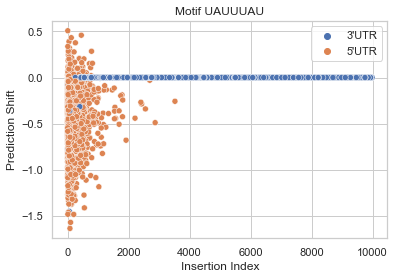

In [ ]:
sns.set_theme(style="whitegrid")

# Make an example dataset with y ~ x
y = y_motif - y_untouched
x = indices

d = {"Insertion Index": indices, "Prediction Shift": y.squeeze(), "IsUTR5": np.array(isinUTR5)}

df = pd.DataFrame(data = d)
'''
y_utr5 = y[np.array(isinUTR5)]
y_utr3 = y[np.array(isinUTR5)==False]

x_utr5 = x[np.array(isinUTR5)]
x_utr3 = x[np.array(isinUTR5)==False]

df_1 = pd.DataFrame()
df_2 = pd.DataFrame()

df_1['region'] = 'A'
df_2['region'] = 'B'
df = pd.concat([df_1,df_2])
'''

#sns.residplot(x=x_utr3, y=y_utr3, color="orange", label = "3'UTR")
#sns.residplot(x=x_utr5, y=y_utr5, color="b", label = "5'UTR", data = df_2, hue = 'region')

sns.scatterplot(data = df, x = "Insertion Index", y =  "Prediction Shift", hue = "IsUTR5")
plt.legend(loc='upper right')
plt.title("Motif UAUUUAU")